### Forecast de demanda: Facturapp

#### Conexión de datos

In [8]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [3]:
from dateutil.relativedelta import relativedelta

# Asegúrate de que la columna 'fecha_venta' esté en formato de fecha
ventas_df['fecha_venta'] = pd.to_datetime(ventas_df['fecha_venta'])

# Encontrar la fecha mínima y máxima
fecha_min = ventas_df['fecha_venta'].min()
fecha_max = ventas_df['fecha_venta'].max()

# Calcular la diferencia en años y meses
diferencia = relativedelta(fecha_max, fecha_min)

# Mostrar la diferencia
print(f"La diferencia es de {diferencia.years} años y {diferencia.months} meses")


La diferencia es de 2 años y 1 meses


In [3]:
clientes_df.head()

,id,razon_soc,nombre_fantasia,pais,departamento,ciudad,activo,tipo_cliente
0,3,DELICIAS SANTI,NaN,URUGUAY,CERRO LARGO,MELO,N,NaN
1,9,ALICIA PEREIRA,NaN,URUGUAY,CERRO LARGO,MELO,N,NaN
2,10,CHIVETERIA ROXANA,NaN,URUGUAY,CERRO LARGO,MELO,N,NaN
3,13,AUTOSERVICE Y PANADERIA AUCHI,NaN,URUGUAY,CERRO LARGO,MELO,N,NaN
4,15,RESTAURANT LA VASCA,NaN,URUGUAY,CERRO LARGO,MELO,N,NaN


In [37]:
productos_df.head()

,codigo_producto,descripcion_producto,costo_producto,precio_producto,stock_actual_producto,unidad_de_medida_producto,proveedor_producto,ramo_producto,familia_producto,grupo_producto,marco_producto
0,404,MANTECA DOS AROLLOS KG,180.000,216.00,0.00,Uni,Proveedor de la Empresa,Sin asignar,ISSUE,TINTAS,NaN
1,3,COMPRA EXENTO IVA,0.000,0.00,12.47,Uni,Proveedor de la Empresa,VACIO2,DANICA,COMPRAS,NaN
2,5932,ALIMENTO SPECIAL DOG CARNE ADULTO 20KG,27.080,33.85,0.00,Uni,MANIZAL S.A,ALIMENTO MASCOTAS,PERROS,Sin asignar,SPECIAL DOG
3,250401,ENCENDEDOR INMINENT CLASICO (DISP 50 UNI) (20 ...,801.786,1002.00,1.00,Uni,MABLE S.A,HOGAR,VARIOS,Sin asignar,INMINENT
4,1077,BANDEJA BOLW 4 445BN,0.381,0.50,366.00,Uni,NaN,EMPAQUES,BANDEJA,Sin asignar,NaN


In [38]:
ventas_df.head()

,codigo_producto,moneda_venta,id_cliente,fecha_venta,monto_ventas_producto,cantidad_ventas_producto
0,0,$,1241,2022-12-30,0.0,1.0
1,0,$,1258,2022-12-16,0.0,1.0
2,0,$,1201,2024-01-30,0.0,1.0
3,0,$,1260,2023-03-01,0.0,1.0
4,0,$,1403,2023-08-15,0.0,1.0


#### Benchmark

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Supongamos que los datos de ventas ya están en un DataFrame llamado df

# Crear columna con la semana (asumiendo que el DataFrame original tiene una columna 'fecha_venta')
ventas_df['fecha_venta'] = pd.to_datetime(ventas_df['fecha_venta'], errors='coerce')
ventas_df['semana'] = ventas_df['fecha_venta'].dt.to_period('W').apply(lambda r: r.start_time)
df_semana = ventas_df.groupby(['semana', 'codigo_producto'])['cantidad_ventas_producto'].sum().reset_index()

# Reindexar para asegurar que todas las semanas están presentes para cada producto
df_pivot = df_semana.pivot(index='semana', columns='codigo_producto', values='cantidad_ventas_producto').fillna(0)

# Definir un horizonte de predicción de una semana
horizon = 1

# Inicializar diccionarios para guardar las métricas por producto
metrics = {'RMSE': {}, 'MAE': {}, 'MAPE': {}, 'R2': {}}

# Evaluar el modelo Naive y Promedio Móvil para cada producto
for product in df_pivot.columns:
    # Obtener la serie temporal para el producto
    series = df_pivot[product]
    
    # Crear predicciones usando el modelo Naive
    naive_forecast = series.shift(horizon)
    
    # Crear predicciones usando un promedio móvil (ventana de 3 semanas)
    moving_average_forecast = series.rolling(window=3).mean().shift(horizon)
    
    # Eliminar los valores nulos (ocurren al hacer shift y promedio móvil)
    valid_idx_naive = naive_forecast.dropna().index
    valid_idx_ma = moving_average_forecast.dropna().index
    
    y_true_naive = series.loc[valid_idx_naive]
    y_pred_naive = naive_forecast.loc[valid_idx_naive]
    
    y_true_ma = series.loc[valid_idx_ma]
    y_pred_ma = moving_average_forecast.loc[valid_idx_ma]
    
    # Calcular las métricas para Naive
    rmse_naive = np.sqrt(mean_squared_error(y_true_naive, y_pred_naive))
    mae_naive = mean_absolute_error(y_true_naive, y_pred_naive)
    mape_naive = np.mean(np.abs((y_true_naive - y_pred_naive) / y_true_naive.replace(0, np.nan))) * 100
    r2_naive = r2_score(y_true_naive, y_pred_naive)
    
    # Guardar las métricas para Naive
    metrics['RMSE'][f'Naive_{product}'] = rmse_naive
    metrics['MAE'][f'Naive_{product}'] = mae_naive
    metrics['MAPE'][f'Naive_{product}'] = mape_naive
    metrics['R2'][f'Naive_{product}'] = r2_naive
    
    # Calcular las métricas para Promedio Móvil
    rmse_ma = np.sqrt(mean_squared_error(y_true_ma, y_pred_ma))
    mae_ma = mean_absolute_error(y_true_ma, y_pred_ma)
    mape_ma = np.mean(np.abs((y_true_ma - y_pred_ma) / y_true_ma.replace(0, np.nan))) * 100
    r2_ma = r2_score(y_true_ma, y_pred_ma)
    
    # Guardar las métricas para Promedio Móvil
    metrics['RMSE'][f'MA_{product}'] = rmse_ma
    metrics['MAE'][f'MA_{product}'] = mae_ma
    metrics['MAPE'][f'MA_{product}'] = mape_ma
    metrics['R2'][f'MA_{product}'] = r2_ma

# Convertir las métricas en un DataFrame para visualización
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


KeyboardInterrupt: 

In [ ]:
df_pivot

codigo_producto,0,00,000,0000,0001,0002,0003,00038,00039,0004,...,PRE0131,Q233,Q236,Q253,QU3262,SADI0032,SADI0168,YG3246,YG5055,YG5056
semana,,,,,,,,,,,,,,,,,,,,,
2022-04-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,1.0
2022-04-18,0.0,0.0,0.0,0.0,16.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,19.0,21.0
2022-04-25,0.0,0.0,0.0,69.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.000,0.0,0.390,0.0,0.0,0.0,15.0,14.0
2022-05-02,0.0,0.0,0.0,28.0,1.0,14.0,28.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.366,0.0,0.0,0.0,20.0,26.0
2022-05-09,0.0,0.0,0.0,40.0,3.0,5.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.804,0.0,0.0,0.0,23.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.450,0.0,0.000,0.0,0.0,28.0,18.0,47.0
2024-05-06,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.0,2.0,4.375,0.0,0.000,0.0,0.0,25.0,31.0,47.0
2024-05-13,0.0,0.0,1.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.415,0.0,0.000,0.0,0.0,10.0,21.0,37.0


In [ ]:
metrics_df

,RMSE,MAE,MAPE,R2
Naive_0,0.300150,0.090090,83.333333,-0.761905
MA_0,0.259381,0.097859,88.888889,-0.293420
Naive_00,5.020678,2.000000,209.237954,-0.498104
MA_00,3.973408,1.681957,134.128004,0.076404
Naive_000,1.739835,1.063063,99.708333,-0.676677
...,...,...,...,...
MA_YG3246,10.756929,7.605505,134.536061,0.326843
Naive_YG5055,35.316714,21.288288,78.635314,0.255813
MA_YG5055,31.428819,20.859327,100.089914,0.414270
Naive_YG5056,43.886627,27.405405,182.868984,-0.095444


#### Benchmark: ARIMA

In [4]:
import pandas as pd

# Lista de códigos de producto que quieres filtrar
codigos_producto = ['5932', '59', '60']

# Filtrar el DataFrame original para que solo incluya las filas con los códigos de producto especificados
ventas_filtradas_df = ventas_df[ventas_df['codigo_producto'].isin(codigos_producto)]

# Crear la tabla agregada con los datos filtrados
tabla_agrupada = ventas_filtradas_df.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum'),
    cantidad_clientes=pd.NamedAgg(column='id_cliente', aggfunc=lambda x: x.nunique())
).reset_index()

# Agregar columna de cantidad_feriados con ceros
tabla_agrupada['flag_feriado'] = 0

# Pivotear las ventas de cada código de producto
ventas_por_producto = ventas_filtradas_df.pivot_table(index='fecha_venta', columns='codigo_producto', values='cantidad_ventas_producto', aggfunc='sum', fill_value=0)

# Renombrar las columnas con un prefijo para que coincida con tu formato
ventas_por_producto.columns = [f'codigo_producto_{col}' for col in ventas_por_producto.columns]

# Unir las tablas
df_arima = pd.merge(tabla_agrupada, ventas_por_producto, on='fecha_venta', how='left')

# Mostrar la tabla final
df_arima.head(10)


,fecha_venta,cantidad_ventas_producto,cantidad_clientes,flag_feriado,codigo_producto_59,codigo_producto_5932,codigo_producto_60
0,2022-04-18,1.0,1,0,0.0,0.0,1.0
1,2022-04-20,7.0,3,0,0.0,2.0,5.0
2,2022-04-21,2.0,2,0,0.0,0.0,2.0
3,2022-04-22,7.0,3,0,0.0,0.0,7.0
4,2022-04-23,6.0,1,0,0.0,0.0,6.0
5,2022-04-26,8.0,3,0,0.0,0.0,8.0
6,2022-04-28,11.0,2,0,0.0,0.0,11.0
7,2022-04-30,1.0,1,0,0.0,0.0,1.0
8,2022-05-02,13.0,2,0,5.0,3.0,5.0
9,2022-05-04,2.0,2,0,1.0,1.0,0.0


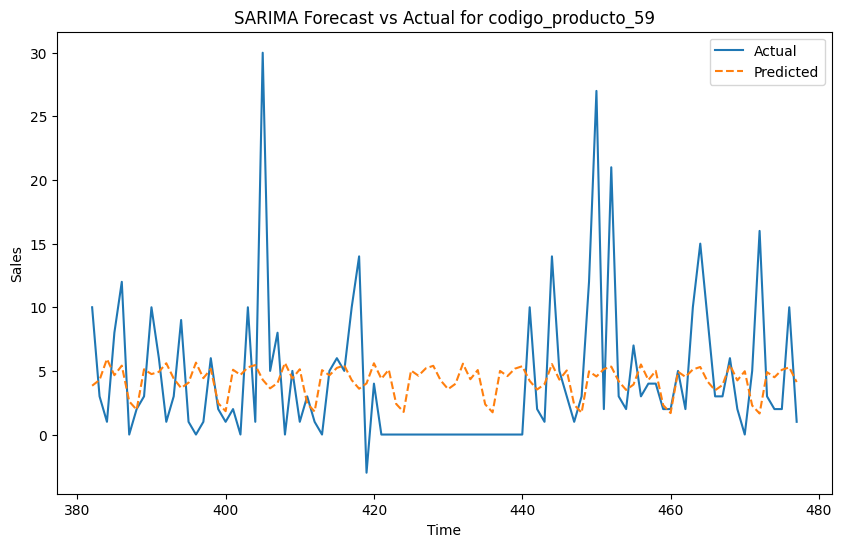

,actual,predicted
382,10.0,3.835918
383,3.0,4.289991
384,1.0,5.937443
385,8.0,4.663131
386,12.0,5.414611


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

column_to_forecast = 'codigo_producto_59'

train_size = int(len(df_arima) * 0.8)
train, test = df_arima[column_to_forecast][:train_size], df_arima[column_to_forecast][train_size:]

model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

predictions = model_fit.forecast(steps=len(test))

df_forecast = pd.DataFrame({
    'actual': test.values,
    'predicted': predictions
})

plt.figure(figsize=(10, 6))
plt.plot(df_forecast['actual'], label='Actual')
plt.plot(df_forecast['predicted'], label='Predicted', linestyle='--')
plt.title(f'SARIMA Forecast vs Actual for {column_to_forecast}')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

df_forecast.head()


#### Opción 2: skforecast

### Opciones avanzadas

#### Opción avanzada 1: Temporal Fusion Transformers (TFT)

#### Opción avanzada 2: DeepAR (a través de GluonTS)

#### Opción avanzada 3: TimeGPT

In [5]:
import os
import pandas as pd
from nixtlats import TimeGPT
#from src.utils import plot

timegpt = TimeGPT(os.environ['TIMEGPT_TOKEN'])

#Load historical data
historic_df = pd.read_csv('electricity.csv')

#Predict the future
forecast_df = timegpt.forecast(historic_df, h = 24)

#Visualize
#plot(historic_df, forecast_df)

KeyError: 'TIMEGPT_TOKEN'